In [13]:
import os
import numpy as np
from datetime import datetime

def parse_timestamp(ts_str):
    return datetime.fromtimestamp(int(ts_str) / 1000.0)

def parse_measurements(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_measurements_{run_number}.log")
    parsed = []
    parsed_shifted = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 20:
                continue
            ts = parse_timestamp(parts[0])
            ts_real = parse_timestamp(parts[1])
            matrix = np.array(list(map(float, parts[4:])), dtype=np.float32).reshape(4, 4)
            parsed.append({'timestamp': ts, 'data': matrix})
            parsed_shifted.append({'timestamp': ts_real, 'data': matrix})
    return parsed, parsed_shifted

def parse_robotstate(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_robotstate_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 25:
                continue
            ts = parse_timestamp(parts[0])
            pose_matrix = np.array(list(map(float, parts[1:17]))).reshape(4, 4)
            joint_config = list(map(float, parts[17:24]))
            state = float(parts[24])
            parsed.append({
                'timestamp': ts,
                'data': pose_matrix,
                'joints': joint_config,
                'state': state
            })
    return parsed

def parse_kalmanfilter(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_kalmanfilter_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 16:
                print("ga")
                continue
            ts = parse_timestamp(parts[0])
            position = list(map(float, parts[1:4]))
            velocity = list(map(float, parts[4:7]))
            matrix = np.array(list(map(float, parts[7:])), dtype=np.float32).reshape(3, 3)
            parsed.append({'timestamp': ts, 'position': position, 'velocity': velocity, 'orientation': matrix})
    return parsed

def parse_controller_input(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_controllerinput_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17:
                continue
            ts = parse_timestamp(parts[0])
            matrix = np.array(list(map(float, parts[1:])), dtype=np.float32).reshape(4, 4)
            parsed.append({'timestamp': ts, 'data': matrix})
    return parsed

def parse_filtered_position(exp_hash, run_number, log_dir='.'):
    path = os.path.join(log_dir, f"{exp_hash}_filteredposition_{run_number}.log")
    parsed = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 4:
                continue
            ts = parse_timestamp(parts[0])
            position = list(map(float, parts[1:4]))
            parsed.append({'timestamp': ts, 'position': position})
    return parsed


In [14]:

exp_hash = '#1'
run_number = 1
log_dir = '/dev/shm/'


In [15]:
import matplotlib.pyplot as plt

SHADE_COLORS = [
    "#f0e442", "#56b4e9", "#e69f00", "#009e73",
    "#d55e00", "#cc79a7", "#0072b2", "#999999",
    "#bcbcbc", "#e0bbff", "#ffd999", "#a1d99b"
]

PLOT_COLORS = {
    'robotstate': '#1f77b4',    # blue
    'measurements': '#ff7f0e',  # orange
    'kalman': '#2ca02c',        # green
    'controller': '#d62728',    # red
}

def plot_position_comparison(
    axis,
    exp_hash, 
    run_number,
    log_dir,
    visibility=[1, 1, 1, 1,1],
    visible_states=[2],
    shade_states=False
):
    
    measurements, measurements_shifted = parse_measurements(exp_hash, run_number, log_dir)
    robotstate = parse_robotstate(exp_hash, run_number, log_dir)
    kalman = parse_kalmanfilter(exp_hash, run_number, log_dir)
    controller_input = parse_controller_input(exp_hash, run_number, log_dir)
    filtered = parse_filtered_position(exp_hash, run_number, log_dir)
    
    axis_map = {'x': 0, 'y': 1, 'z': 2}
    if axis not in axis_map:
        raise ValueError("axis must be one of 'x', 'y', 'z'")
    idx = axis_map[axis]

    # === 1. Determine start/end time from robotstate for selected states
    state_set = set(visible_states)
    timestamps = [entry['timestamp'] for entry in robotstate if int(entry['state']) in state_set]
    if not timestamps:
        raise ValueError(f"No robotstate entries found for states {visible_states}")
    start_time = min(timestamps)
    end_time = max(timestamps)

    # === 2. Convert entries to (relative_time_in_seconds, value) pairs
    def process(data, get_value_fn):
        return [
            ((entry['timestamp'] - start_time).total_seconds(), get_value_fn(entry))
            for entry in data
            if start_time <= entry['timestamp'] <= end_time
        ]

    rs_data = process(robotstate, lambda e: e['data'][:3, 3][idx]) if visibility[0] else []
    meas_data = process(measurements, lambda e: e['data'][:3, 3][idx]) if visibility[1] else []
    kf_data = process(kalman, lambda e: e['position'][idx]) if visibility[2] else []
    ctrl_data = process(controller_input, lambda e: e['data'][:3, 3][idx]) if visibility[3] else []

    # === 3. Begin plotting
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    if rs_data:
        times, values = zip(*rs_data)
        ax.scatter(times, values, label='Robot State', s=1, color=PLOT_COLORS['robotstate'])

    if meas_data:
        times, values = zip(*meas_data)
        ax.scatter(times, values, label='Measurements', s=1, color=PLOT_COLORS['measurements'])

    if kf_data:
        times, values = zip(*kf_data)
        ax.scatter(times, values, label='Kalman Filter', s=1, color=PLOT_COLORS['kalman'])

    if ctrl_data:
        times, values = zip(*ctrl_data)
        ax.scatter(times, values, label='Controller Input', s=1, color=PLOT_COLORS['controller'])

    # === 4. Optional shaded regions (no text)
    if shade_states:
        segments = []
        current_state = None
        current_start = None

        for entry in robotstate:
            t = entry['timestamp']
            s = int(entry['state'])

            if t < start_time:
                continue
            if t > end_time:
                break

            if s != current_state:
                if current_state is not None:
                    segments.append((current_start, t))
                current_state = s
                current_start = t

        if current_state is not None:
            segments.append((current_start, end_time))

        for i, (seg_start, seg_end) in enumerate(segments):
            rel_start = (seg_start - start_time).total_seconds()
            rel_end = (seg_end - start_time).total_seconds()
            color = SHADE_COLORS[i % len(SHADE_COLORS)]
            ax.axvspan(rel_start, rel_end, facecolor=color, alpha=0.1)

    # === 5. Final formatting
    state_range_str = f"{visible_states[0]}–{visible_states[-1]}" if len(visible_states) > 1 else str(visible_states[0])
    plt.title(f"{axis.upper()} Position (States: {state_range_str})")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis.upper()} Position (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
import matplotlib.pyplot as plt

# === Global fixed colors ===
DATA_COLORS = {
    'robotstate': '#1f77b4',    # blue
    'measurements': '#ff7f0e',  # orange
    'measurements_shifted': '#9467bd', 
    'kalman': '#2ca02c',        # green
    'controller': '#d62728'     # red
}

STATE_COLORS = {
    0: "#f9dc24",  # bright yellow
    1: "#1b9e77",  # teal green
    2: "#377eb8",  # medium blue
    3: "#e41a1c",  # red
    4: "#984ea3",  # purple
    5: "#ff7f00",  # vivid orange
    6: "#4daf4a",  # forest green
    7: "#a65628",  # brown
}

def plot_position_comparison(
    axis,
    exp_hash, 
    run_number,
    log_dir,
    visibility=[1, 1, 1, 1],
    visible_states=[2],
    shade_states=False
):
    
    measurements, measurements_shifted = parse_measurements(exp_hash, run_number, log_dir)
    robotstate = parse_robotstate(exp_hash, run_number, log_dir)
    kalman = parse_kalmanfilter(exp_hash, run_number, log_dir)
    controller_input = parse_controller_input(exp_hash, run_number, log_dir)
    filtered = parse_filtered_position(exp_hash, run_number, log_dir)

    axis_map = {'x': 0, 'y': 1, 'z': 2}
    if axis not in axis_map:
        raise ValueError("axis must be one of 'x', 'y', 'z'")
    idx = axis_map[axis]

    state_set = set(visible_states)
    timestamps = [entry['timestamp'] for entry in robotstate if int(entry['state']) in state_set]
    if not timestamps:
        raise ValueError(f"No robotstate entries found for states {visible_states}")
    start_time = min(timestamps)
    end_time = max(timestamps)

    def process(data, get_value_fn):
        return [
            ((entry['timestamp'] - start_time).total_seconds(), get_value_fn(entry))
            for entry in data
            if start_time <= entry['timestamp'] <= end_time
        ]

    rs_data = process(robotstate, lambda e: e['data'][:3, 3][idx]) if visibility[0] else []
    meas_data = process(measurements, lambda e: e['data'][:3, 3][idx]) if visibility[1] else []

    kf_data = process(kalman, lambda e: e['position'][idx]) if visibility[2] else []
    ctrl_data = process(controller_input, lambda e: e['data'][:3, 3][idx]) if visibility[3] else []
    
    meas_sh_data = process(measurements_shifted, lambda e: e['data'][:3, 3][idx]) if visibility[4] else []


    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    if rs_data:
        times, values = zip(*rs_data)
        ax.scatter(times, values, label='Robot State', s=1, color=DATA_COLORS['robotstate'], alpha=0.3)

    if meas_data:
        times, values = zip(*meas_data)
        ax.scatter(times, values, label='Measurements', s=3, color=DATA_COLORS['measurements'], alpha=0.3)

    if kf_data:
        times, values = zip(*kf_data)
        ax.scatter(times, values, label='Kalman Filter', s=1, color=DATA_COLORS['kalman'], alpha=0.3)

    if ctrl_data:
        times, values = zip(*ctrl_data)
        ax.scatter(times, values, label='Controller Input', s=1, color=DATA_COLORS['controller'], alpha=0.3)
    
    if meas_sh_data:
        times, values = zip(*meas_sh_data)
        ax.scatter(times, values, label='Measurements shifted', s=3, color=DATA_COLORS['measurements_shifted'], alpha=0.3)
        
    if shade_states:
        segments = []
        current_state = None
        current_start = None

        for entry in robotstate:
            t = entry['timestamp']
            s = int(entry['state'])
            if t < start_time:
                continue
            if t > end_time:
                break
            if s != current_state:
                if current_state is not None:
                    segments.append((current_start, t, current_state))
                current_state = s
                current_start = t
        if current_state is not None:
            segments.append((current_start, end_time, current_state))

        for seg_start, seg_end, seg_state in segments:
            rel_start = (seg_start - start_time).total_seconds()
            rel_end = (seg_end - start_time).total_seconds()
            color = STATE_COLORS.get(seg_state, '#eeeeee')
            ax.axvspan(rel_start, rel_end, facecolor=color, alpha=0.07)

    state_range_str = f"{visible_states[0]}–{visible_states[-1]}" if len(visible_states) > 1 else str(visible_states[0])
    plt.title(f"{axis.upper()} Position (States: {state_range_str})")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis.upper()} Position (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
"""
MoveToStartingPoint 0
RestartServer 1
Idle 2
Registration 3
ComputingApproachPoint 4 
Approaching 5
VisualServoing 6 
Lifting 7
"""

"""
robotstate
measurements
kalman
controller_input
"""

'\nrobotstate\nmeasurements\nkalman\ncontroller_input\n'

In [18]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


DATA_COLORS = {
    'robotstate': '#1f77b4',    # blue
    'measurements': '#ff7f0e',  # orange
    'measurements_shifted': '#9467bd', 
    'kalman': '#2ca02c',        # green
    'controller': '#d62728'     # red
}

STATE_COLORS = {
    0: "#f9dc24",  # bright yellow
    1: "#1b9e77",  # teal green
    2: "#377eb8",  # medium blue
    3: "#e41a1c",  # red
    4: "#984ea3",  # purple
    5: "#ff7f00",  # vivid orange
    6: "#4daf4a",  # forest green
    7: "#a65628",  # brown
}

def plot_orientation_comparison_for_run(
    axis,
    exp_hash, 
    run_number,
    log_dir,
    visible_states=[2],
    visibility=[1, 1, 1,1], # robotstate, controller_input, measurements, filtered
    shade_states=False,
):
    angle_map = {'roll': 0, 'pitch': 1, 'yaw': 2}
    if axis not in angle_map:
        raise ValueError("axis must be one of 'roll', 'pitch', or 'yaw'")
    idx = angle_map[axis]

    # Load data
    robotstate = parse_robotstate(exp_hash, run_number, log_dir)
    controller_input = parse_controller_input(exp_hash, run_number, log_dir)
    measurements, measurements_shifted = parse_measurements(exp_hash, run_number, log_dir)    
    filtered_orient = parse_kalmanfilter(exp_hash, run_number, log_dir)


    # Determine start and end time from first visible state
    state_set = set(visible_states)
    timestamps = [entry['timestamp'] for entry in robotstate if int(entry['state']) in state_set]
    if not timestamps:
        raise ValueError(f"No robotstate entries found for states {visible_states}")
    start_time = min(timestamps)
    end_time = max(timestamps)

    def extract_rpy(matrix):
        rot = matrix[:3, :3]
        return R.from_matrix(rot).as_euler('xyz', degrees=True)

    def process(entries, extract_matrix_fn):
        return [
            ((entry['timestamp'] - start_time).total_seconds(), extract_rpy(extract_matrix_fn(entry))[idx])
            for entry in entries
            if start_time <= entry['timestamp'] <= end_time
        ]

    rs_data = process(robotstate, lambda e: e['data']) if visibility[0] else []
    ctrl_data = process(controller_input, lambda e: e['data']) if visibility[1] else []
    meas_data = process(measurements, lambda e: e['data']) if visibility[2] else []
    flt_data = process(filtered_orient, lambda e: e['orientation']) if visibility[3] else []
    # Plot
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    if rs_data:
        times, values = zip(*rs_data)
        ax.scatter(times, values, label="Robot State", s=1, color=DATA_COLORS['robotstate'], alpha=0.3)

    if ctrl_data:
        times, values = zip(*ctrl_data)
        ax.scatter(times, values, label="Controller Input", s=1, color=DATA_COLORS['controller'], alpha=0.3)

    if meas_data:
        times, values = zip(*meas_data)
        ax.scatter(times, values, label="Measurements", s=1, color=DATA_COLORS['measurements'], alpha=0.3)
    
    if flt_data:
        times, values = zip(*flt_data)
        ax.scatter(times, values, label="Filtered", s=1, color=DATA_COLORS['kalman'], alpha=0.3)

    if shade_states:
        segments = []
        current_state = None
        current_start = None

        for entry in robotstate:
            t = entry['timestamp']
            s = int(entry['state'])
            if t < start_time:
                continue
            if t > end_time:
                break
            if s != current_state:
                if current_state is not None:
                    segments.append((current_start, t, current_state))
                current_state = s
                current_start = t
        if current_state is not None:
            segments.append((current_start, end_time, current_state))

        for seg_start, seg_end, seg_state in segments:
            rel_start = (seg_start - start_time).total_seconds()
            rel_end = (seg_end - start_time).total_seconds()
            color = STATE_COLORS.get(seg_state, '#eeeeee')
            ax.axvspan(rel_start, rel_end, facecolor=color, alpha=0.1)

    state_range_str = f"{visible_states[0]}–{visible_states[-1]}" if len(visible_states) > 1 else str(visible_states[0])
    plt.title(f"{axis.capitalize()} Orientation (States: {state_range_str})")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis.capitalize()} (degrees)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


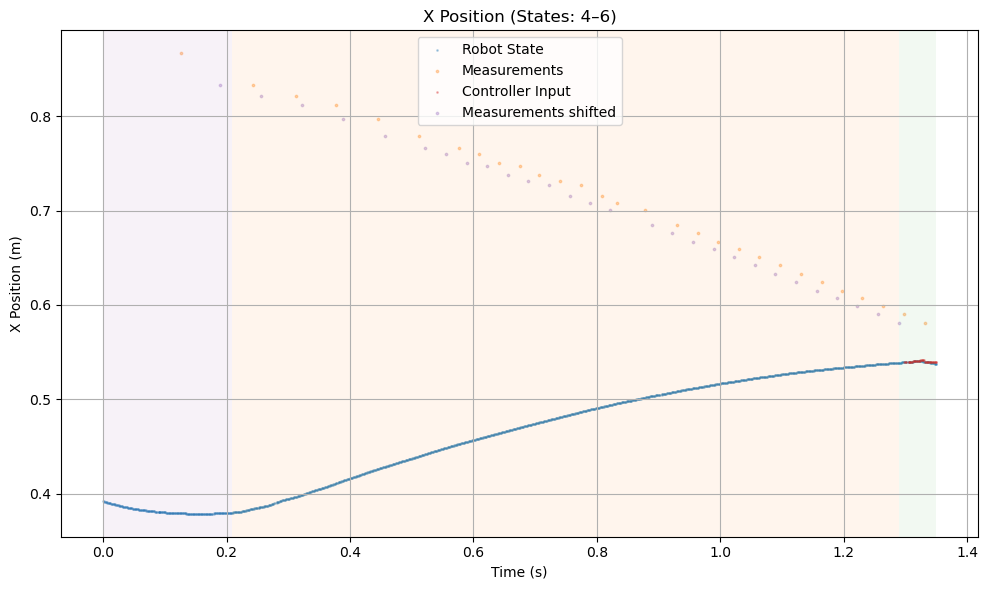

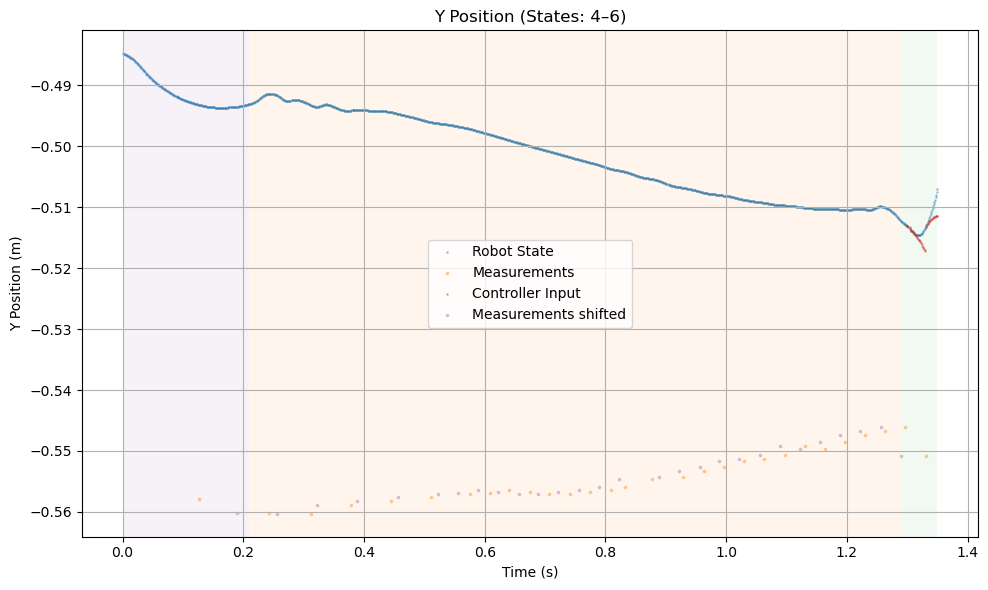

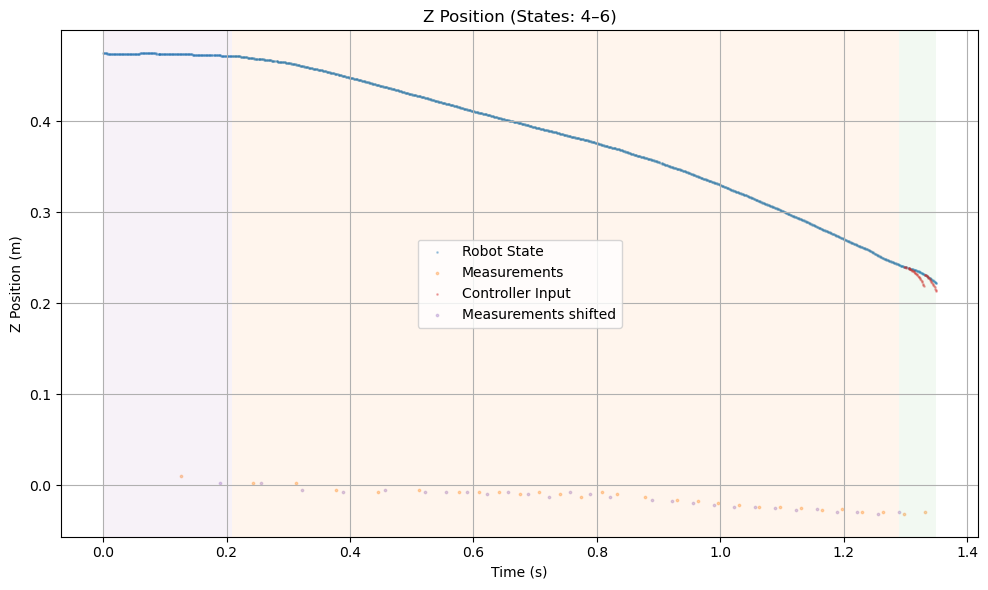

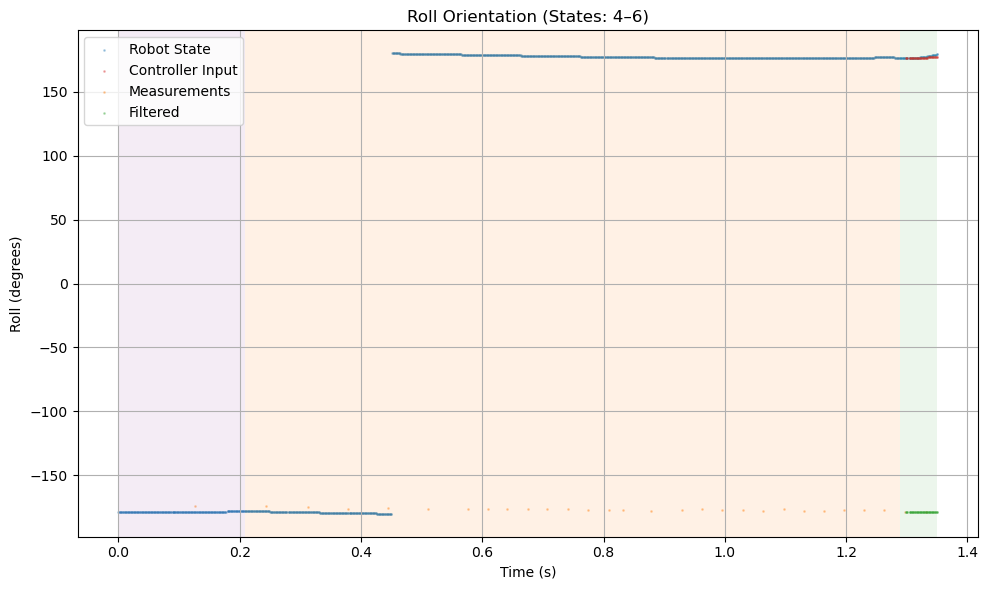

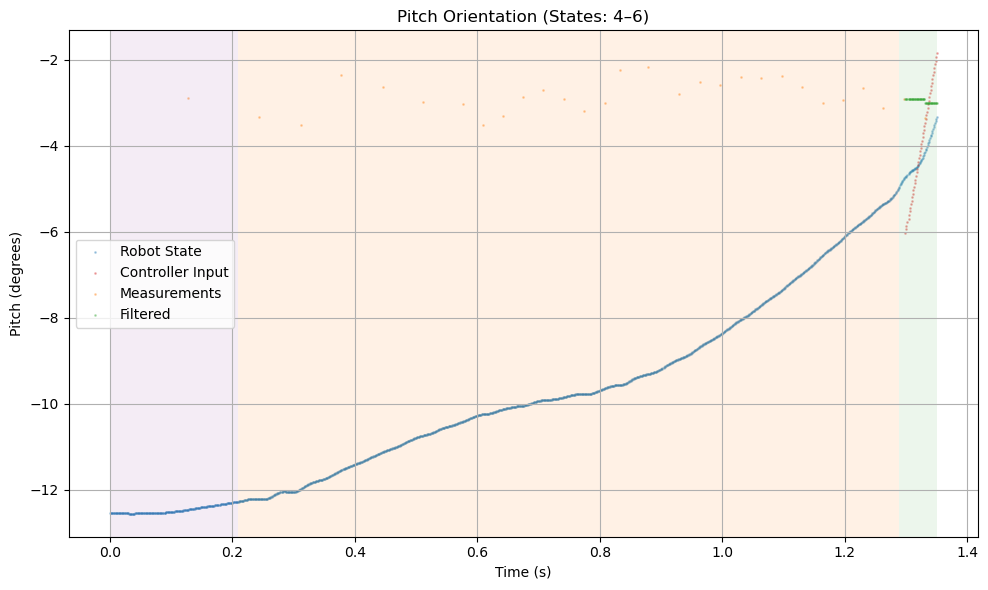

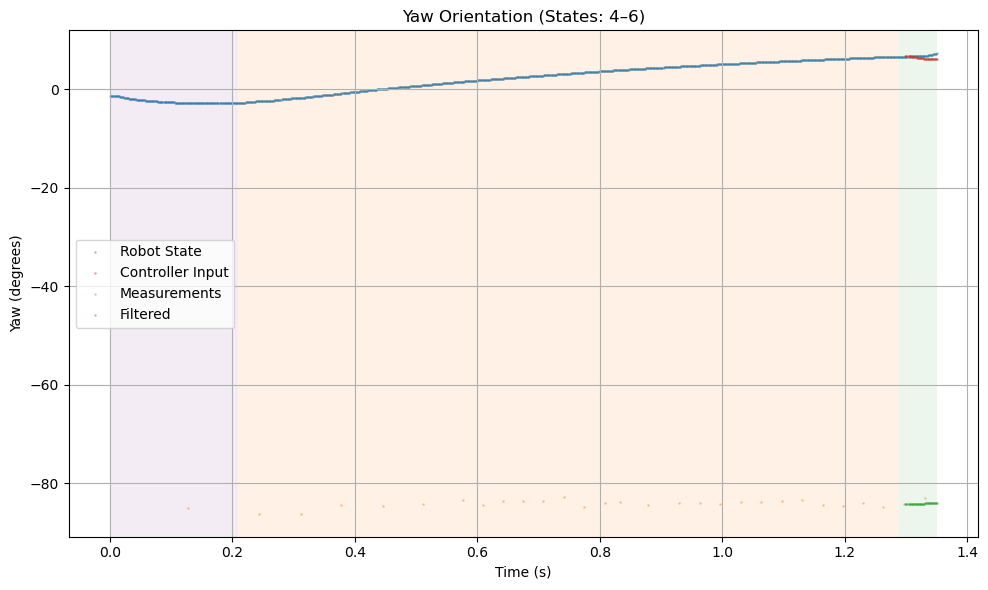

In [21]:
hash_ = "#1"
exp_ = 1
dir_= '/dev/shm/experiment/default'
states_ = [4,5,6]
for dim in ['x', 'y', 'z']:
    plot_position_comparison(
        dim,
        hash_,
        exp_,
        dir_,
        visibility=[1,1,0,1,1],
        visible_states=states_,
        shade_states=True
    )
    
for dim in ['roll', 'pitch', 'yaw']:
    plot_orientation_comparison_for_run(
        dim,
        hash_,
        exp_,
        dir_,
        visible_states=states_,
        visibility=[1, 1, 1,1,1],
        shade_states=True
    )
    


In [20]:
def plot_multi_run_position_comparison(
    axis,
    exp_hashes,
    run_numbers,
    log_dir='.',
    visibility=[1, 1, 1, 1],
    visible_states=[2],
    shade_states=False
):
    axis_map = {'x': 0, 'y': 1, 'z': 2}
    if axis not in axis_map:
        raise ValueError("axis must be one of 'x', 'y', 'z'")
    idx = axis_map[axis]    
    
    if len(exp_hashes) != len(run_numbers):
        raise ValueError("exp_hashes and run_numbers must have the same length")

    # Store all combined data
    combined_data = {
        'robotstate': [],
        'measurements': [],
        'kalman': [],
        'controller': []
    }

    all_timestamps = []

    # === 1. Load and accumulate logs
    for exp_hash, run_number in zip(exp_hashes, run_numbers):
        robot = parse_robotstate(exp_hash, run_number, log_dir)
        meas, meas_shifted = parse_measurements(exp_hash, run_number, log_dir)
        kf = parse_kalmanfilter(exp_hash, run_number, log_dir)
        ctrl = parse_controller_input(exp_hash, run_number, log_dir)

        # Determine shared time window from robotstate for selected states
        timestamps = [e['timestamp'] for e in robot if int(e['state']) in visible_states]
        if not timestamps:
            continue
        start_time = min(timestamps)
        end_time = max(timestamps)
        all_timestamps.append((start_time, end_time))

        def shift_and_filter(data, fn):
            return [
                ((entry['timestamp'] - start_time).total_seconds(), fn(entry), f"{exp_hash}_{run_number}")
                for entry in data
                if start_time <= entry['timestamp'] <= end_time
            ]

        if visibility[0]:
            combined_data['robotstate'].extend(shift_and_filter(robot, lambda e: e['data'][:3, 3][axis_map[axis]]))
        if visibility[1]:
            combined_data['measurements'].extend(shift_and_filter(meas, lambda e: e['data'][:3, 3][axis_map[axis]]))
        if visibility[2]:
            combined_data['kalman'].extend(shift_and_filter(kf, lambda e: e['position'][axis_map[axis]]))
        if visibility[3]:
            combined_data['controller'].extend(shift_and_filter(ctrl, lambda e: e['data'][:3, 3][axis_map[axis]]))

    if not all_timestamps:
        raise ValueError("No valid logs found for given states across any run.")

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    colors = {
        'robotstate': '#1f77b4',
        'measurements': '#ff7f0e',
        'kalman': '#2ca02c',
        'controller': '#d62728'
    }

    for key, label in zip(['robotstate', 'measurements', 'kalman', 'controller'],
                          ['Robot State', 'Measurements', 'Kalman Filter', 'Controller Input']):
        if visibility[['robotstate', 'measurements', 'kalman', 'controller'].index(key)]:
            entries = combined_data[key]
            for run_id in set(e[2] for e in entries):
                run_entries = [(t, v) for (t, v, r) in entries if r == run_id]
                if run_entries:
                    times, values = zip(*run_entries)
                    alpha = 0.1
                    if (key == 'measurements'):
                        alpha=1
                        
                    ax.scatter(times, values, s=0.1, color=colors[key], alpha=alpha)
                
                        
    if shade_states:
        for i, (start, end) in enumerate(all_timestamps):
            rel_start = 0
            rel_end = (end - start).total_seconds()
            shade_color = SHADE_COLORS[i % len(SHADE_COLORS)]
            ax.axvspan(rel_start, rel_end, facecolor=shade_color, alpha=0.25)

    plt.title(f"{axis.upper()} Position Comparison Across Runs")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{axis.upper()} Position (m)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:

plot_multi_run_position_comparison(
    axis='z',
    exp_hashes=[exp_hash] * 1,
    run_numbers=range(1,2),
    log_dir=log_dir,
    visibility=[1, 1, 0, 0],
    visible_states=[3, 4, 5, 6],
    shade_states=False
)

FileNotFoundError: [Errno 2] No such file or directory: '/dev/shm/experiment/#1_robotstate_1.log'

In [10]:
pip3 install seaborn


SyntaxError: invalid syntax (327773905.py, line 1)

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_stat(exp_pair, log_dir):
    stat_total = []
    stat_proc = []
    
    for (exp_hash, run_number) in exp_pair:
        path = os.path.join(log_dir, f"{exp_hash}_measurements_{run_number}.log")
        with open(path, 'r') as f:
            i = 0 
            for line in f:
                parts = line.strip().split()
                if len(parts) != 19:
                    continue
                ts = int(parts[0])
                s_real = int(parts[1])
                tracking_time = int(parts[2])
                if i < 2:
                    #print(ts - s_real)    
                    pass    
                else:
                    stat_total.append(ts - s_real)
                    stat_proc.append(tracking_time)
                if (2 < i< 2):
                    print("i--->",ts - s_real, tracking_time)
                i += 1
        #print("-----------")
    stat_total = np.array(stat_total)
    stat_proc= np.array(stat_proc)
    
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # First strip plot
    sns.stripplot(x=stat_total, jitter=True, s=3, ax=axs[0])
    axs[0].set_title("total")
    axs[0].set_xlabel("Value")
    axs[0].tick_params(axis='x', labelbottom=True)
    # Second strip plot
    sns.stripplot(x=stat_proc, jitter=True,s =3, ax=axs[1])
    axs[1].set_title("proc")
    axs[1].set_xlabel("Value")

    plt.tight_layout()
    plt.show()
                     
    return (np.max(stat_total), np.mean(stat_total), np.std(stat_total), np.var(stat_total)),  (np.max(stat_proc), np.mean(stat_proc), np.std(stat_proc), np.var(stat_proc)),

In [12]:
hash_ = "wifi"
exp_ = 1
dir_1= '/dev/shm/experiment/5gexp'
dir_2= '/dev/shm/experiment/ethexp'
exp_pair_1 = [
    ("#1", 1),
    ("#2", 1),
    ("#2", 2),
    ("#3", 1),
    ("#4", 1),
    ("#5", 1),
    ("#6", 1),
    ("#7", 1),
    ("#7", 2),
    ("#7", 3),
    ("#8", 1),
    ("#9", 1),
    ("#9", 2),
    ("#9", 3),
    ("#9", 4),
    ("#10", 1),
    ("#11", 1),
]
exp_pair_2 = [
    ("#1", 1),
    ("#1", 2),
    ("#2", 1),
    ("#3", 1),
    ("#3", 2),
    ("#3", 3),
    ("#4", 1),
    ("#5", 1),
    ("#5", 2),
    ("#5", 3),
    ("#5", 4),
    ("#6", 1),
    ("#7", 1),
    ("#8", 1),
    ("#9", 1),
    ("#9", 2),
    ("#10", 1),
    ("#10", 2),
    ("#11", 1),
]
print(compute_stat(exp_pair_1, dir_1))
print(compute_stat(exp_pair_2, dir_2))

FileNotFoundError: [Errno 2] No such file or directory: '/dev/shm/experiment/5gexp/#1_measurements_1.log'

In [ ]:
hash_ = "wifi"
exp_ = 1

exp_pair_d = [
    ("#1", 1),
    ("#1", 2),
    ("#1", 3),
    ("#1", 4),
    ("#1", 5),
    ("#1", 6),
    ("#1", 7),
    ("#1", 8),
    ("#1", 9),
    ("#1", 10),
    ("#1", 11),
    ("#1", 12),
    ("#1", 13),
    
]

print(compute_stat(exp_pair_d, '/dev/shm/experiment/default'))